### TRAINING CHAMBON 2018 WITH PHYSIOEX DATA

In [ ]:
from physioex.physioex.train.utils import train, test
from physioex.physioex.data import PhysioExDataModule

datamodule = PhysioExDataModule(
    datasets=["sleepedf"],     # list of datasets to be used
    batch_size=64,             # batch size for the DataLoader
    preprocessing="raw",       # preprocessing method
    selected_channels=["EEG"], # channels to be selected
    sequence_length=21,        # length of the sequence
    data_folder="./data",      # path to the data folder
)

# get the DataLoaders
train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()
test_loader = datamodule.test_dataloader()

print(len(train_loader)) # number of batches in the training set
print(len(val_loader)) # number of batches in the validation set
print(len(test_loader)) # number of batches in the test set

checkpoint_path = "./model/checkpoint/"

2036
570
409


In [ ]:
import os
import yaml
import importlib

# with open("./physioex/physioex/train/networks/config/chambon2018.yaml", "r") as file:
with open("./config.yaml", "r") as file:
    config = yaml.safe_load(file)

print(config)
network_config = config["model_config"]

print(network_config)

# load the loss function 
loss_package, loss_class = network_config["loss_call"].split(":")
model_loss = getattr(importlib.import_module(loss_package), loss_class)

print(model_loss)

# in case you provide model_name the system loads the additional model parameters from the library
if "model_name" in config:
    model_name = config["model_name"]
    # load the loss function 
    model_package, model_loader = network_config["loss_call"].split(":")
    model = getattr(importlib.import_module(model_package), model_loader)

print(model_name)

# load the model class
model_package, model_class = config["module"].split(":")
model_class = getattr(importlib.import_module(model_package), model_class)

print(model_class)

{'model_config': {'loss_call': 'physioex.train.networks.utils.loss:CrossEntropyLoss', 'loss_params': {}, 'sequence_length': 21, 'n_classes': 5, 'in_channels': 1, 'sf': 100, 'n_times': 3000, 'learning_rate': '1e-4', 'adam_beta_1': 0.9, 'adam_beta_2': 0.999, 'adam_epsilon': '1e-8', 'latent_space_dim': 32, 'input_processing': 'raw'}, 'checkpoint_path': './model/checkpoint/', 'input_transform': 'raw', 'model': 'physioex.train.networks.chambon2018:Chambon2018Net', 'model_name': 'chambon2018', 'module': 'physioex.train.networks:Chambon2018Net', 'preprocessing': 'raw', 'target_transform': 'physioex.train.networks.utils.target_transform:get_mid_label'}
{'loss_call': 'physioex.train.networks.utils.loss:CrossEntropyLoss', 'loss_params': {}, 'sequence_length': 21, 'n_classes': 5, 'in_channels': 1, 'sf': 100, 'n_times': 3000, 'learning_rate': '1e-4', 'adam_beta_1': 0.9, 'adam_beta_2': 0.999, 'adam_epsilon': '1e-8', 'latent_space_dim': 32, 'input_processing': 'raw'}
<class 'physioex.train.networks.

In [ ]:
datamodule_kwargs = {
    "selected_channels" : ["EEG"], # needs to match in_channels
    "sequence_length" : network_config["sequence_length"],
    "target_transform" : config["target_transform"],
    "preprocessing" : config["input_transform"],
    "data_folder" : "./data",
}

# Train the model
best_checkpoint = train(
    datasets = datamodule,
    datamodule_kwargs = datamodule_kwargs,
    model_class = model_class,
    model_config = network_config,
    checkpoint_path = checkpoint_path,
    batch_size = 64,
    max_epochs = 10
)

# Test the model
results_dataframe = test(
    datasets = datamodule,
    datamodule_kwargs = datamodule_kwargs,
    model_class = model_class,
    model_config = network_config,
    chekcpoint_path = os.path.join( checkpoint_path, best_checkpoint ),
    batch_size = 64,
    results_dir = checkpoint_path,  # if you want to save the test results 
                                    # in your checkpoint directory
)

### TRAINING SIMPLE CNN WITH SIMULATED DATA

In [1]:
# Load and shape synthetic data
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

x = None
y = None

# load the data from synthetic data
data_folder = "./data/synthetic/train_3"
data_files = os.listdir(data_folder)
for file in data_files:
    if "samples_0" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.zeros(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.zeros(5000)])
    elif "samples_1" in file:
        if x is None and y is None:
            x = np.load(os.path.join(data_folder, file))
            y = np.ones(5000)
        else:
            x = np.concatenate([x, np.load(os.path.join(data_folder, file))])
            y = np.concatenate([y, np.ones(5000)])
    else:
        print("File not recognized")
        continue
    

x = x[:, np.newaxis, :]

print(x.shape)
print(y.shape)

# convert the data to torch tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# create the dataset
dataset = TensorDataset(x, y)

# create the DataLoader
train_loader = DataLoader(dataset, batch_size=128, shuffle=True)


(50000, 1, 16)
(50000,)


In [2]:
# print the shape of the dataloader
print(len(train_loader))
for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break

391
torch.Size([128, 1, 16])
torch.Size([128])


In [3]:
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, epochs=20, lr=0.001):
    device = torch.device("mps" if torch.backends.mps.is_available else "cpu")
    print(device)
    model.to(device)  # Move model to GPU if available

    criterion = nn.CrossEntropyLoss()  # Binary classification loss
    optimizer = optim.Adam(model.parameters(), lr=lr)  # Adam optimizer

    # implement early stopping
    best_loss = float('inf')
    patience = 5
    counter = 0
    stopping_threshold = 0.001

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Clear previous gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Early stopping
        if (best_loss - running_loss) > stopping_threshold:
            print(f"Loss improved from {best_loss:.4f} to {running_loss:.4f}")
            best_loss = running_loss
            counter = 0
        else:
            counter += 1
            print(f"Loss did not improve. Counter: {counter}/{patience}")
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        train_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_acc:.4f}")

    print("Training complete!")


In [4]:
# train the SimpleCNN model
from src.models.simple import SimpleCNN

model = SimpleCNN(in_channels=1, out_channels=2, hidden_size=64, kernel_size=5)

# Train the model
train_model(model, train_loader, epochs=30, lr=0.001)


/Users/alicia/Documents/Master/TFM/learnable-masks-explainability-time-series/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps
Loss improved from inf to 55.1177
Epoch 1/30, Loss: 0.1410, Accuracy: 0.9739
Loss improved from 55.1177 to 1.0664
Epoch 2/30, Loss: 0.0027, Accuracy: 1.0000
Loss improved from 1.0664 to 0.3186
Epoch 3/30, Loss: 0.0008, Accuracy: 1.0000
Loss improved from 0.3186 to 0.1473
Epoch 4/30, Loss: 0.0004, Accuracy: 1.0000
Loss improved from 0.1473 to 0.0819
Epoch 5/30, Loss: 0.0002, Accuracy: 1.0000
Loss improved from 0.0819 to 0.0505
Epoch 6/30, Loss: 0.0001, Accuracy: 1.0000
Loss improved from 0.0505 to 0.0333
Epoch 7/30, Loss: 0.0001, Accuracy: 1.0000
Loss improved from 0.0333 to 0.0229
Epoch 8/30, Loss: 0.0001, Accuracy: 1.0000
Loss improved from 0.0229 to 0.0163
Epoch 9/30, Loss: 0.0000, Accuracy: 1.0000
Loss improved from 0.0163 to 0.0119
Epoch 10/30, Loss: 0.0000, Accuracy: 1.0000
Loss improved from 0.0119 to 0.0089
Epoch 11/30, Loss: 0.0000, Accuracy: 1.0000
Loss improved from 0.0089 to 0.0067
Epoch 12/30, Loss: 0.0000, Accuracy: 1.0000
Loss improved from 0.0067 to 0.0051
Epoch 13/3

In [5]:
# save the model
torch.save(model.state_dict(), "./model/checkpoint/simpleCNN_5.pth")


## Testing data generation

Filtering 3 with lowpass
Filtering 5 with highpass
Filtering 3 with lowpass
Filtering 5 with highpass
Filtering 3 with lowpass
Filtering 5 with highpass
Filtering 3 with lowpass
Filtering 5 with highpass
Filtering 3 with lowpass
Filtering 5 with highpass


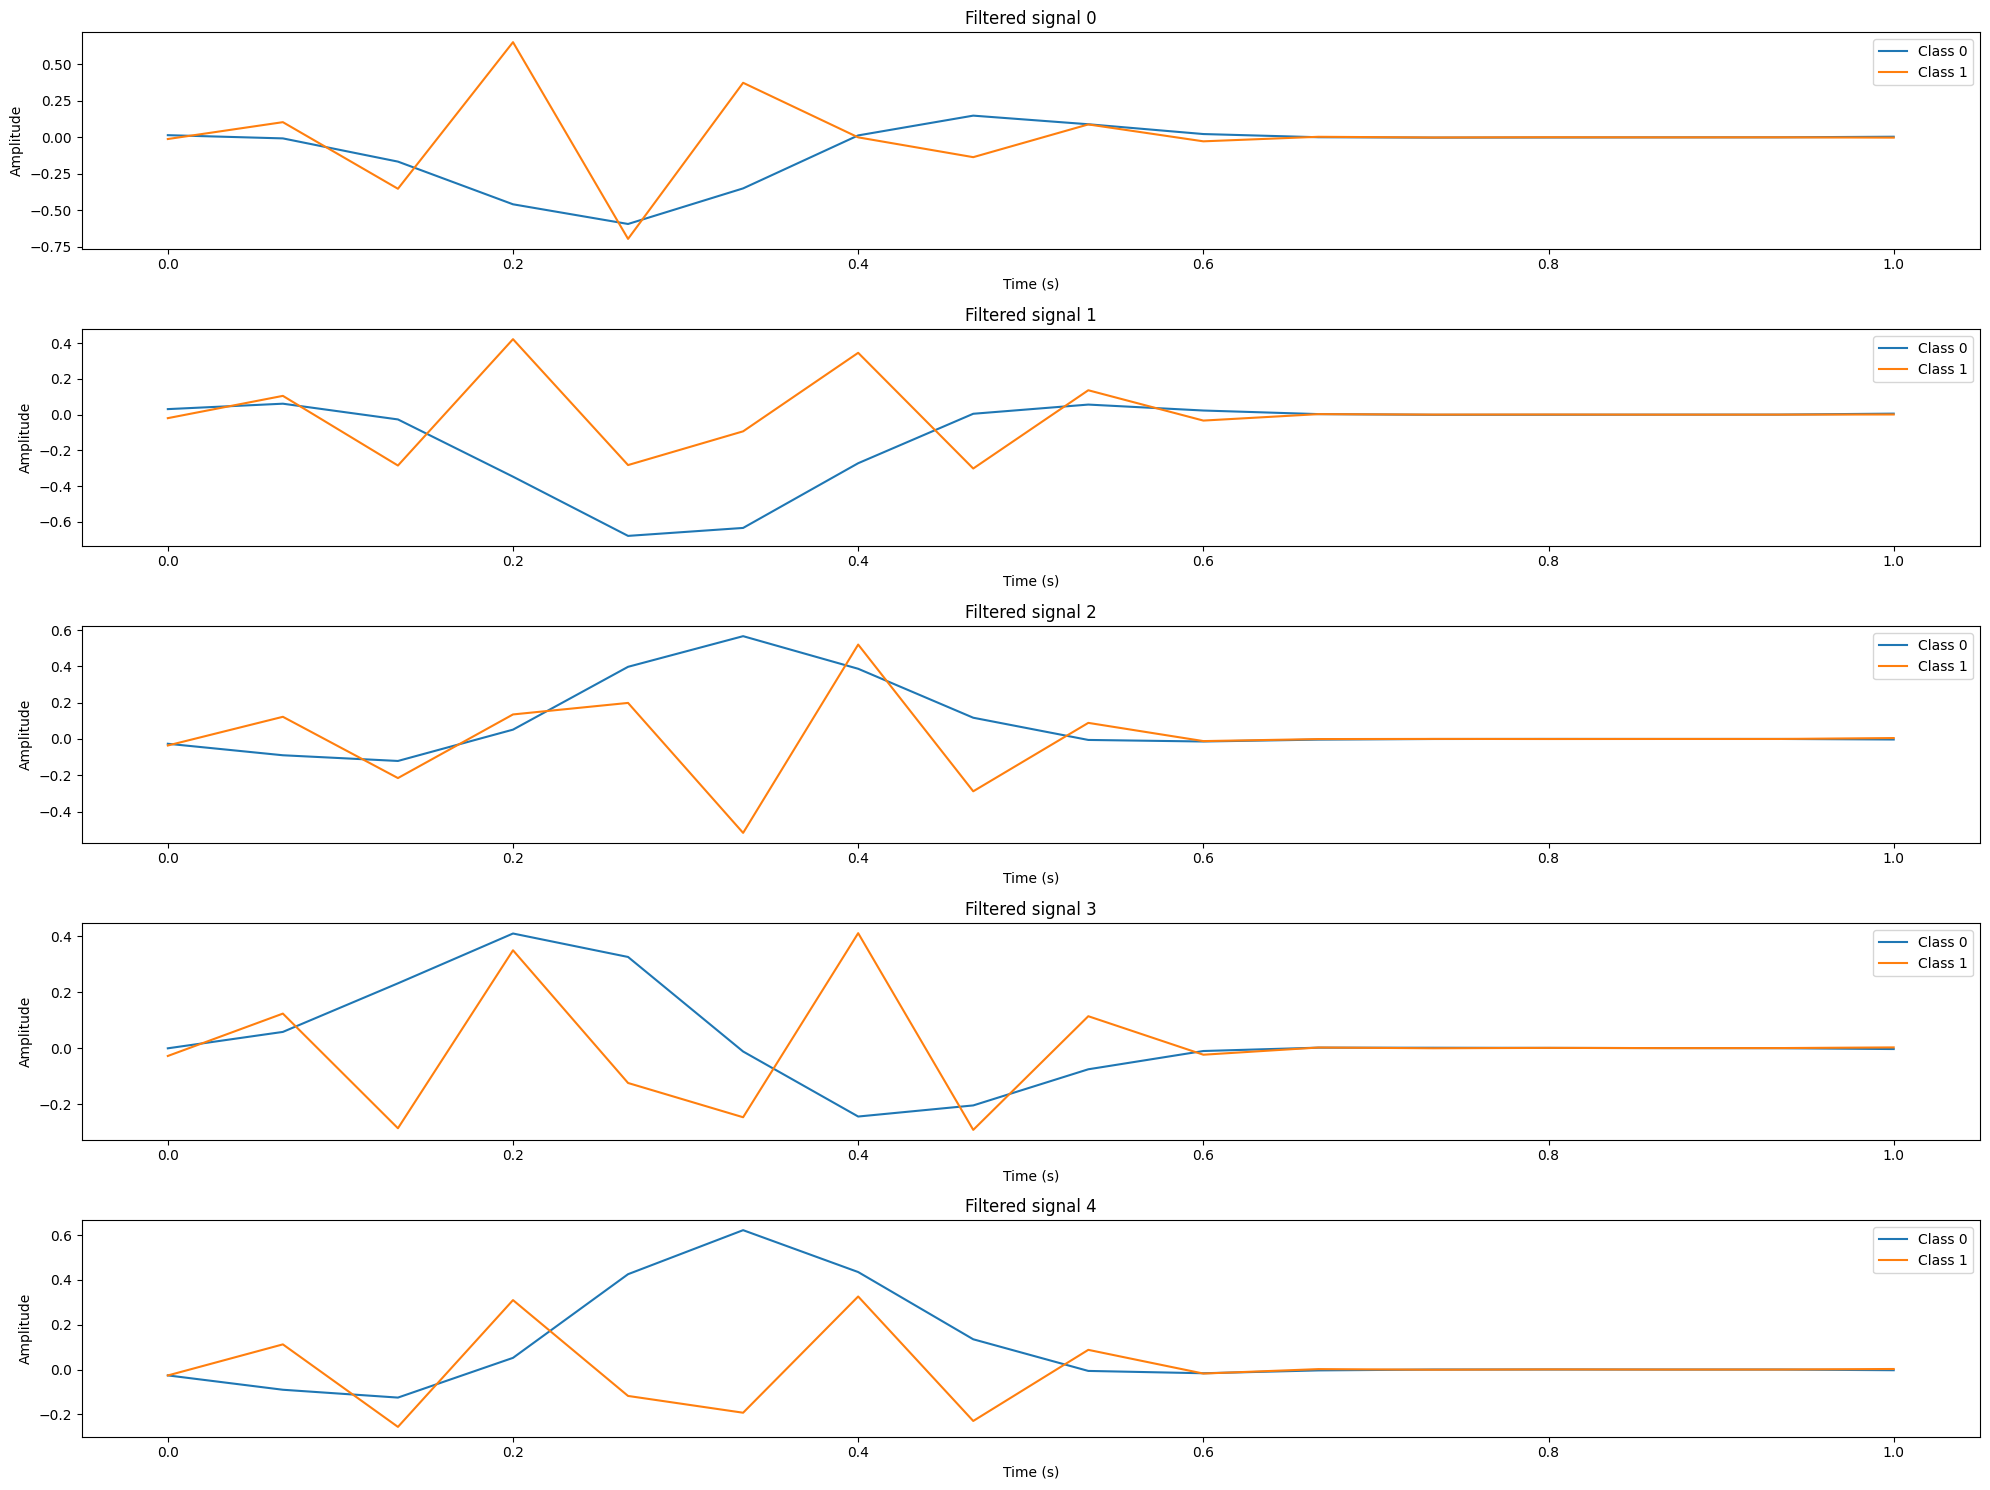

In [34]:
import os
import numpy as np
from src.data_gen.synthetic import generate_singal_filtered
import matplotlib.pyplot as plt

# generate the synthetic data
SEED = 33

np.random.seed(SEED)  # For reproducibility

num_samples = 1     # Number of samples per class
fs = 16             # Sampling rate
T = 1               # Duration in seconds
N = fs * T          # Number of samples

t = np.linspace(0, T, N)

freqs_0 = [2]     # salient frequencies
freqs_1 = [6]     # salient frequencies
times_0 = [0.3]   # salient times
# times_1 = [0.7]   # salient times
ampls = [1]       # amplitudes

# folders for train and test data
folder_train = "./data/synthetic/train_2/"
folder_test = "./data/synthetic/test_2/"

# create the folder if it does not exist
if not os.path.exists(folder_train):
    os.makedirs(folder_train)

if not os.path.exists(folder_test):
    os.makedirs(folder_test)

length = 5

# create figures
fig, axs = plt.subplots(length, 1, figsize=(20, 15))


# genrate the data
for i in range(length):
    # generate sequences of samples
    samples_0 = [generate_singal_filtered(frequencies=freqs_0, times=times_0, amplitudes=ampls, fs=fs, T=T, noise_level=0.001, jitter=0.0, cutoff=3) for _ in range(num_samples)]
    samples_1 = [generate_singal_filtered(frequencies=freqs_1, times=times_0, amplitudes=ampls, fs=fs, T=T, noise_level=0.001, jitter=0.0, cutoff=5) for _ in range(num_samples)]

    axs[i].plot(t, samples_0[0], label="Class 0")
    axs[i].plot(t, samples_1[0], label="Class 1")
    axs[i].set_title("Filtered signal %d" % i)
    axs[i].set_xlabel("Time (s)")
    axs[i].set_ylabel("Amplitude")
    axs[i].legend()
    # # create the npy files
    # np.save(folder_train + "samples_0_%d.npy" % i, samples_0)
    # np.save(folder_train + "samples_1_%d.npy" % i, samples_1)

fig.tight_layout()

# for i in range(2):
#     # generate sequences of samples
#     samples_0 = [generate_singal_filtered(frequencies=freqs_0, times=times_0, amplitudes=ampls, fs=fs, T=T, noise_level=0.001, jitter=0.0) for _ in range(num_samples)]
#     samples_1 = [generate_singal_filtered(frequencies=freqs_1, times=times_0, amplitudes=ampls, fs=fs, T=T, noise_level=0.001, jitter=0.0) for _ in range(num_samples)]

    # # create the npy files
    # np.save(folder_test + "samples_0_%d.npy" % i, samples_0)
    # np.save(folder_test + "samples_1_%d.npy" % i, samples_1)


# plt.subplot(2, 1, 1)
# plt.plot(t, samples_0[0], label="Class 0")
# plt.plot(t, samples_1[0], label="Class 1")
# plt.title("Filtered signal")
# plt.subplot(2, 1, 2)
# plt.plot(t, samples_0[0][1)
# plt.title("Filtered Class 0")
# plt.show()

# plt.subplot(2, 1, 2)
# plt.plot(t, samples_1[0][1])
# plt.title("Filtered Class 0")
# plt.show()
# plt.legend()
# plt.show()


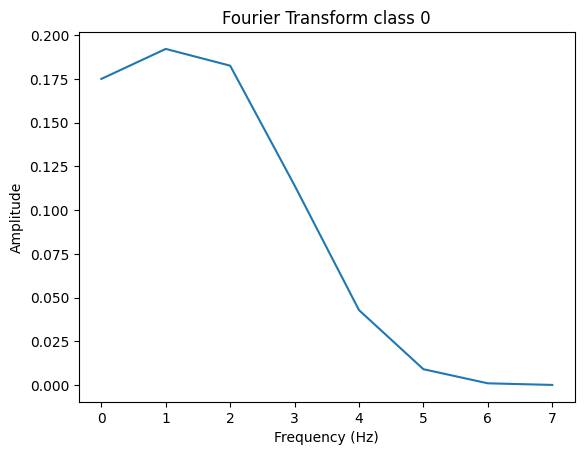

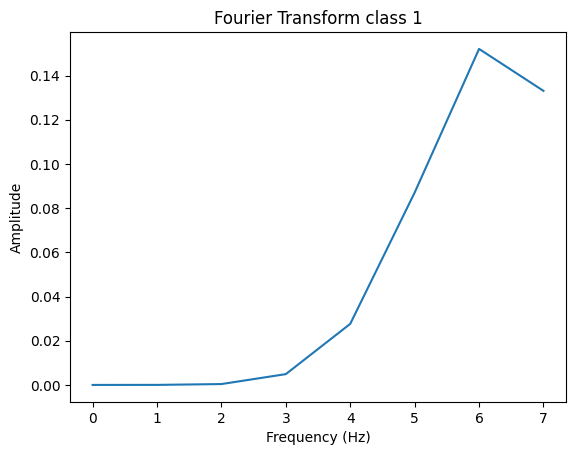

In [35]:
# plot fourier transform of the signal
from scipy.fft import fft, fftfreq

def plot_fourier_transform(signal, fs, num):
    N = len(signal)
    T = 1.0 / fs
    yf = fft(signal)
    xf = fftfreq(N, T)[:N//2]
    
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.title(f"Fourier Transform class {num}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

# plot the fourier transform of the signal
plot_fourier_transform(samples_0[0], fs, 0)
# plot_fourier_transform(samples_0[0][1], fs)

# plot the fourier transform of the signal
plot_fourier_transform(samples_1[0], fs, 1)
# plot_fourier_transform(samples_1[0][1], fs)


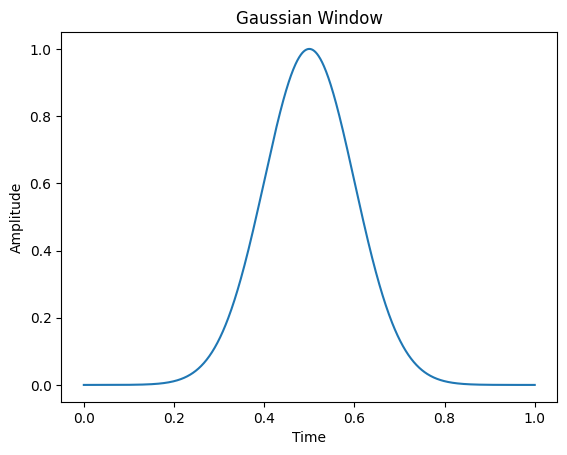

In [36]:
import matplotlib.pyplot as plt

t = np.linspace(0, 1, 1000)
t_var = 0.5
T_pulse = 0.1
window = np.exp(-((t - t_var)**2) / (2 * T_pulse**2))

plt.plot(t, window)
plt.title("Gaussian Window")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()


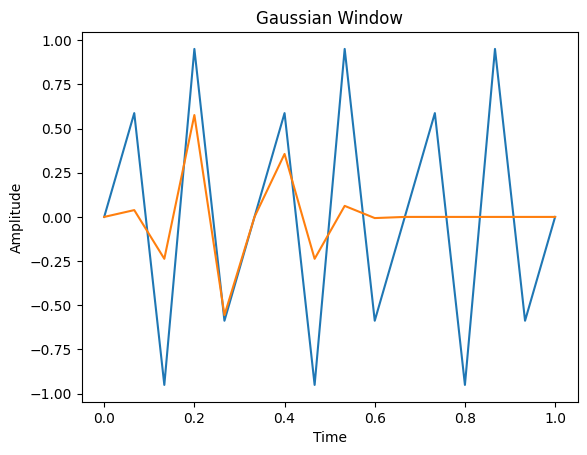

In [37]:
fs = 16
T = 1
t_burst = 0.1
f = 6
t_burst_center = 0.3

t = np.linspace(0, T, fs * T)

sigma = t_burst
window = np.exp(-((t - t_burst_center)**2) / (2 * sigma**2))

signal = np.sin(2 * np.pi * f * t)
windowed = np.sin(2 * np.pi * f * t) * window

plt.plot(t, signal)
plt.plot(t, windowed)
plt.title("Gaussian Window")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

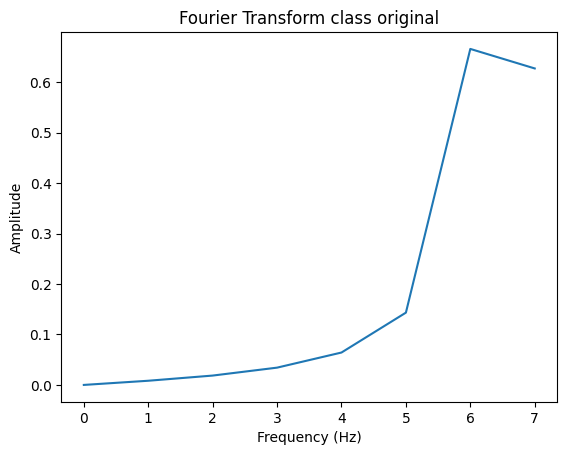

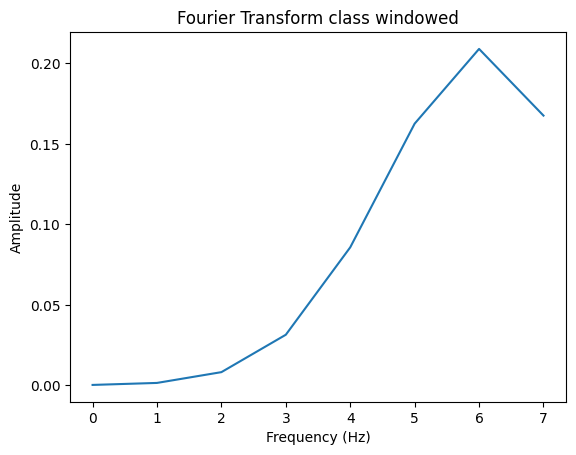

In [38]:
# print fft of the signal
plot_fourier_transform(signal, fs, 'original')
plot_fourier_transform(windowed, fs, 'windowed')

